In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.key_dataset import remove_overlaps, select_keys, create_windows, KeyDataset
from src.data.filter import Filter
from src.data.utils import bipolar_conversion, load_data, key_counts, load_data_deprecated
from src.visualization.visualize import layout
from src.utils import load_config
from src.models.keydecoder import KeyDecoder
from src.models.train import train
from src.models.utils import Experiment

import importlib
import operator
from functools import reduce

/home/john/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [9]:
rhythm_layout = ['a', 's', 'd', 'f']
binary_layout = [0, 1]
right_layout = ['j', 'k', 'l', ';']
six_finger_layout = ['a', 's', 'd', 'f', 'g', 'h']
two_fingers_layout = ['g', 'h']
window_pre = 800
window_post = 800
subwindow_len = 480

In [34]:
data_dir = "/home/john/rumi/data/"


# expt_names=["kenfu_2024-04-09-1048_Rhythm-Game-Typing-Task"]
expt_names = ["kenfu_2024-04-09-1114_Open-Loop-Typing-Task"]



def get_data(expt_list, layout):
    datasets = []

    for expt_name in expt_list:
        key_fname = data_dir + expt_name + "/data_streams/key_stream.bin"
        emg_fname = data_dir + expt_name + "/data_streams/emg_stream.bin"
        key_data = load_data(key_fname)
        emg_data = load_data(emg_fname)
        emg_names = ['emgbuffer'] + list(emg_data.dtype.names)[1:]
        key_names = ['keybuffer'] + list(key_data.dtype.names)[1:]
        emg_data.dtype.names = emg_names
        key_data.dtype.names = key_names
        print(key_data[:10])
# #         print(emg_data.shape)
# #         for i in range(0, 100):
# #            print(emg_data[i][-1])
#         new_key_data = np.zeros(key_data.size, 
#                                 dtype=[('keybuffer', '<i8', (3,)), ('emg_stream_step', '<i8'), ('key_stream_step', '<i8'), ('time_ns', '<i8')])
#         new_key_data['keybuffer'] = np.concatenate((np.zeros_like(key_data['keybuffer'][:, 1:2]), 
#                                                 key_data['keybuffer']), axis=1)
#         new_key_data['emg_stream_step'] = key_data['emg_stream_step']
#         new_key_data['key_stream_step'] = key_data['key_stream_step']
#         new_key_data['time_ns'] = key_data['time_ns']

        emg_stream = emg_data['emgbuffer']
        
        dataset = KeyDataset(emg_stream, key_data, layout, window_pre, window_post, subwindow_len,
                             start_channel=1, 
                             end_channel=65, bipolar=True, avg_ref=False, binary=False, 
                             include_blanks=False, 
                             limit_blanks=False,
                             filter_params=None)

        datasets.append(dataset)
    full = reduce(operator.add, datasets)
    full.print_counts()
    data = full.to_numpy(include_full_windows=True)
    return data

In [35]:

data = get_data(expt_names, six_finger_layout)
print(data.dtype)
# data_test = get_data(expt_names_test, six_finger_layout)
# data['key_label'][np.where(data['key_label'] == ord('a'))] = 0
# data['key_label'][np.where(data['key_label'] == ord('s'))] = 0
# data['key_label'][np.where(data['key_label'] == ord('d'))] = 1
# data['key_label'][np.where(data['key_label'] == ord('f'))] = 1
# full_dataset.balance_classes(time_shift=False, add_noise=True)

[([                  0,                   0,                 106, 1712686531149203409,                   0], 24479, 0, 1712686531151903933)
 ([                  0,                   0,                 106, 1712686531648724593,                   1], 26437, 1, 1712686531652154081)
 ([                  0,                   0,                 106, 1712686531679242534,                   2], 26571, 2, 1712686531682143219)
 ([                  0,                   0,                 106, 1712686531710296385,                   3], 26706, 3, 1712686531712051680)
 ([                  0,                   0,                 106, 1712686531740907199,                   4], 26841, 4, 1712686531742027226)
 ([                  0,                   0,                 106, 1712686531770946219,                   5], 26949, 5, 1712686531772209292)
 ([                  0,                   0,                 106, 1712686531800768101,                   6], 27077, 6, 1712686531802328087)
 ([                 

In [36]:
data.dtype

dtype([('full_windows', '<f8', (1600, 32)), ('emg_windows', '<f8', (480, 32)), ('key_label', '<i8')])

In [37]:
data

array([],
      dtype=[('full_windows', '<f8', (1600, 32)), ('emg_windows', '<f8', (480, 32)), ('key_label', '<i8')])

In [25]:
# emg_data = data_test['emg_windows']
# boxcar = [1]*20
# print(emg_data.shape)
# smoothed_data = np.zeros(((emg_data.shape[0], emg_data.shape[2], emg_data.shape[1])))
# for i in range(emg_data.shape[0]):
#     for j in range(emg_data.shape[2]):
#         smoothed_data[i, j] = np.convolve(np.abs(emg_data[i, :, j]), boxcar, mode='same')

In [26]:
# smoothed_avg = np.sum(smoothed_data, axis=1)/32

In [27]:
# y = smoothed_avg
# x = np.arange(0,480)
# for i in range(0, 300):
# #     if(chr(data['key_label'][i]) != 's'):
# #         continue
#     plt.figure(i)
#     #plt.axvline(x=340, color='black')
#     #plt.axvline(x=660, color='black')
#     plt.title(chr(int(data['key_label'][i])))
# #     plt.axvline(x=480)
# #     plt.axvline(x=1000-240)
# #     plt.axvline(x=1000+240)
#     for j in range(0,32):
# #         if(j==22):
# #             continue
#         plt.plot(x, y[i, :])
#     plt.show()

In [28]:
# mapping = {'a': 0, 's': 5, 'd': 1, 'f': 2, 'g': 3, 'h': 4}
# print([mapping[chr(i)] for i in data['key_label'][:50]])

In [29]:
# y = data['full_windows']
# x = np.arange(0,800*2)
# for i in range(0, 300):
# #     if(chr(data['key_label'][i]) != 's'):
# #         continue
#     plt.figure(i)
#     #plt.axvline(x=340, color='black')
#     #plt.axvline(x=660, color='black')
#     plt.title(chr(int(data['key_label'][i])))
#     #plt.axvline(x=1240)
#     #plt.axvline(x=760)
#     #plt.axvline(x=480)
#     #plt.axvline(x=800)
#     #plt.axvline(x=1000)
#     plt.axvline(x=1000)
#     plt.axvline(x=1000-240)
#     plt.axvline(x=1000+240)
#     for j in range(16,32):
# #         if(j==22):
# #             continue
#         plt.plot(x, y[i, :, j])
#     plt.show()

In [30]:
#DATA VIEWING

array([],
      dtype=[('full_windows', '<f8', (1600, 32)), ('emg_windows', '<f8', (480, 32)), ('key_label', '<i8')])

In [31]:
y = data['emg_windows']
x = np.arange(0,480)
for i in range(0, 10):
#     if(chr(data['key_label'][i]) != 's'):
#         continue
    plt.figure(i)
    #plt.axvline(x=340, color='black')
    #plt.axvline(x=660, color='black')
    plt.title(chr(int(data['key_label'][i])))
    #plt.axvline(x=1240)
    #plt.axvline(x=760)
    #plt.axvline(x=480)
    
    #plt.axvline(x=800)
    #plt.axvline(x=1000)
#     plt.axvline(x=2000)
#     plt.axvline(x=2000-240)
#     plt.axvline(x=2000+240)
    for j in range(0, 32):
#         if(j==22):
#             continue
        plt.plot(x, y[i, :, j])
    plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 432x288 with 0 Axes>

In [60]:
# press_probs = [0.4245256, 0.40424472, 0.4732742, 0.45960686, 0.36034346, 0.0056956466, 0.646868, 0.65860033, 0.49513063, 0.6700846, 0.5004693, 0.24690337, 0.05947983, 0.16981317, 0.066428296, 0.294462, 0.31167105, 0.3224459, 0.26402366, 0.14316428, 0.53404427, 0.16661459, 0.21555622, 0.20694734, 0.15845823, 0.30812567, 0.07354336, 0.3636372, 0.2256173, 0.23421372, 0.897329, 0.9999999, 0.8507012, 0.99969935, 0.25037935, 0.1673389, 0.034267742, 0.18198648, 0.89092845, 0.2952422, 0.046150606, 0.51872784, 0.093932025, 0.29779437, 0.11549696, 0.39617056, 0.71209806, 0.36009926, 0.5844185, 0.99846554, 0.9849798, 0.079113364, 0.0057549537, 0.72102165, 0.2471603, 0.71652114, 0.60659367, 0.05758316, 0.16203608, 0.2872308, 0.24603441, 0.47370797, 0.51818585, 0.07076944, 0.18459493, 0.15262412, 0.19298652, 0.08151729, 0.90617216, 0.9491667, 0.78138995, 0.37505096, 0.12859847, 0.16152172, 0.34596545, 0.27549297, 0.002269972, 0.41320133]
# presses = [30, 31, 32, 33, 38, 46, 49, 50, 53, 55, 68, 69, 70]
# #for i in presses:
# #    plt.axvline(x = i, color = 'b')
# length = np.array(press_probs).shape[0]
# x = np.arange(0, length)
# plt.plot(x, press_probs)

In [61]:
#  6

In [62]:
config = load_config("/home/john/emg_decoder/configs/keydecoder.yaml")
train_data, val_test_data = train_test_split(data,
                                            train_size=config['data']['train_proportion'],
                                            stratify=data['key_label'],
                                            random_state=config['random_seed'])

relative_val_proportion = config['data']['val_proportion'] / (1 - config['data']['train_proportion'])

val_data, test_data = train_test_split(val_test_data,
                                      train_size=0.5,
                                       stratify=val_test_data['key_label'],
                                       random_state=config['random_seed'])




train_dataset = KeyDataset(None, None, None, None, None, subwindow_len, init=False, binary=False)
train_dataset.full_windows = train_data['full_windows']
train_dataset.X = train_data['emg_windows']
train_dataset.y = train_data['key_label']
train_dataset.num_chans = train_dataset.X.shape[-1]

train_dataset.print_counts()
#train_dataset.balance_classes(var_factor=3, time_shift=True, add_noise=True)
target = 2000
for class_id in np.unique(train_dataset.y):
    train_dataset.augment_class(class_id, target_num_samples=target, var_factor=4, time_shift=True, add_noise=False, in_place=True)
# train_dataset.augment_class(0, num_views=3, var_factor=3, time_shift=True, add_noise=True, in_place=True)
# train_dataset.augment_class(1, num_views=6, var_factor=3, time_shift=True, add_noise=True, in_place=True)
train_dataset.print_counts()
train_data = train_dataset.to_numpy(include_full_windows=False)

97, a: 79
100, d: 80
102, f: 80
115, s: 80
97.0, a: 2079
100.0, d: 2080
102.0, f: 2080
115.0, s: 2080


In [63]:
name = expt_names[0] + "_binary"
# name = 'shreyas_testing_combined_balanced_noblanks'

print(name)
print(train_dataset.to_numpy(include_full_windows=False).size, val_data.size, test_data.size)
processed_data_dir = "/home/john/emg_decoder/data/processed/"
train_path = processed_data_dir + name + "_train.npy"
val_path = processed_data_dir + name + "_val.npy"
test_path = processed_data_dir + name + "_test.npy"
path = processed_data_dir + name
np.save(train_path, train_dataset.to_numpy(include_full_windows=False))
np.save(val_path, val_data)
##
##
np.save(test_path, test_data)

config['data']['window_length'] = subwindow_len
config['model']['loss'] = 'CrossEntropyLoss'
config['data']['train_path'] = train_path
config['data']['val_path'] = val_path
config['data']['test_path'] = test_path
config['name'] = name
config['root_dir'] = "/home/john/emg_decoder"

kenfu_2024-04-08-1548_Rhythm-Game-Typing-Task_binary
8319 40 40


In [64]:
system_type = KeyDecoder
experiment_dir = f"/home/john/emg_decoder/models/{config['name']}"
accelerator = 'cuda'
devices = [0]

system, trainer = train(
        system_type,
        config,
        experiment_dir=experiment_dir,
        accelerator=accelerator,
        devices=devices,
    run=True
    )

Global seed set to 4995
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/john/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/john/emg_decoder/models/kenfu_2024-04-08-1548_Rhythm-Game-Typing-Task_binary/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
-------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Size([32]) hi
torch.Size([32, 480, 32]) torch.Si

Validation: 0it [00:00, ?it/s]

In [65]:
expt = Experiment(system_type, experiment_dir, version=0)
expt.list_checkpoints()

Versions: ['0', '2', '1'] available, loading version 0...


['bell-epoch=01-val_loss=1.01.ckpt',
 'bell-epoch=06-val_loss=1.17.ckpt',
 'bell-epoch=00-val_loss=1.15.ckpt',
 'bell-epoch=00-val_loss=1.15-v1.ckpt',
 'bell-epoch=01-val_loss=1.00.ckpt',
 'last-v2.ckpt',
 'bell-epoch=08-val_loss=1.42.ckpt',
 'kenfu_2024-04-08-1548_Rhythm-Game-Typing-Task_binary.pt',
 'bell-epoch=00-val_loss=0.91.ckpt',
 'bell-epoch=06-val_loss=1.49.ckpt',
 'bell-epoch=03-val_loss=1.09.ckpt',
 'last.ckpt',
 'bell-epoch=03-val_loss=1.35.ckpt',
 'bell-epoch=02-val_loss=1.31-v1.ckpt',
 'bell-epoch=01-val_loss=1.01-v1.ckpt',
 'last-v1.ckpt',
 'bell-epoch=02-val_loss=1.31.ckpt',
 'bell-epoch=02-val_loss=0.98.ckpt',
 'bell-epoch=03-val_loss=1.35-v1.ckpt']

In [66]:
system.load_from_checkpoint(experiment_dir + "/models/" + "last.ckpt")
trainer.test(system)
out = trainer.predict(system)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4000000059604645
        test_loss           4.7834906578063965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [67]:
Xs = np.concatenate([a[0] for a in out])
ys = np.concatenate([a[1] for a in out])
print(Xs.shape, ys.shape)
preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])
# print(Xs)
# preds = np.hstack([torch.round(torch.nn.functional.sigmoid(a[0])) for a in out])
# print(preds)

(40, 4) (40,)


In [68]:
print(ys)

[2 0 3 2 1 1 3 3 1 0 2 1 3 0 0 1 3 3 2 0 3 3 2 0 1 1 2 1 2 0 1 0 2 1 0 0 2
 2 3 3]


In [69]:
typing_test_layout = [65505, 'a', 'w', 'd', ' ', 'j', 'i', 'o', ';']
asciis = [ord(ch) if type(ch) == str else ch for ch in typing_test_layout]
print(asciis)
# idxs = np.argsort(asciis)
idxs = [0, 2, 3, 4, 5, 1]
print(np.argsort(asciis))
print(np.unique(ys))
reord_ys = np.array([idxs[i] for i in ys])
reord_preds = np.array([idxs[i] for i in preds])
print(reord_ys)
print(preds)

[65505, 97, 119, 100, 32, 106, 105, 111, 59]
[4 8 1 3 6 5 7 2 0]
[0 1 2 3]
[3 0 4 3 2 2 4 4 2 0 3 2 4 0 0 2 4 4 3 0 4 4 3 0 2 2 3 2 3 0 2 0 3 2 0 0 3
 3 4 4]
[2 3 2 3 1 3 1 3 3 2 1 1 0 1 2 3 3 3 0 2 1 3 2 0 1 0 1 1 2 0 1 2 2 3 3 2 2
 0 1 1]


In [70]:
ys

array([2, 0, 3, 2, 1, 1, 3, 3, 1, 0, 2, 1, 3, 0, 0, 1, 3, 3, 2, 0, 3, 3,
       2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 1, 0, 0, 2, 2, 3, 3])

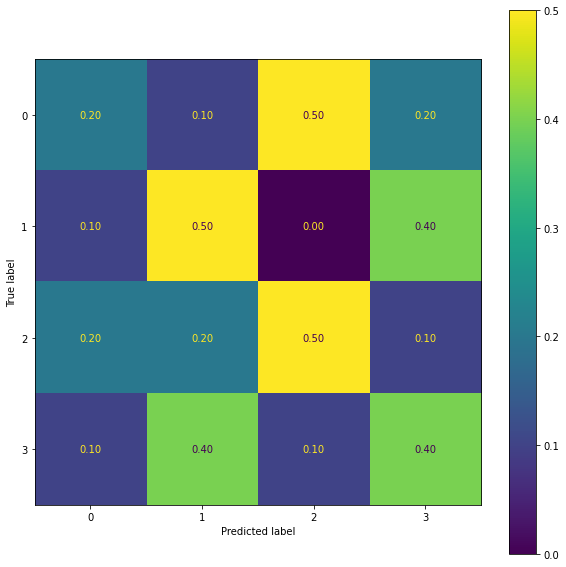

In [71]:
disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f',
                                               )


[97.0, 100.0, 102.0, 115.0]


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (6).

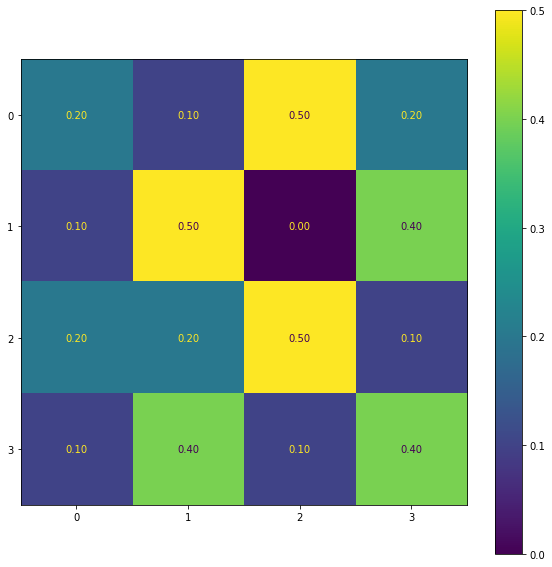

In [72]:
plt.rcParams["figure.figsize"] = (10, 10)
classes = system.classes
print(classes)
classes = [ord('a'), ord('s'), ord('d'), ord('f'), ord('g'), ord('h')]
#classes = [ord("\x00"), ord('q'), ord('a'), ord('z'), ord('w'), ord('s'), ord('x'), ord('e'), ord('d'), ord('c'), ord('r'), ord('f'), ord('v'), ord('t'), ord('g'), ord('b')]
labels = [chr(int(c)) for c in classes]
disp = ConfusionMatrixDisplay.from_predictions(reord_ys, reord_preds, normalize='true', values_format='.2f',
                                               display_labels=[chr(int(i)) if i != 65505 else 'shift' for i in classes])


In [ ]:
torch.save(system.state_dict(), f"{experiment_dir}/models/{config['name']}.pt")

In [ ]:
print(f"{experiment_dir}/models/{config['name']}.pt")

In [ ]:
experiment_dir

In [ ]:
f"{config['name']}.pt"